# Synthetic Desert model MODFLOW 6

This model is based on the Lucerne Valley Hydrologic Model in the Mojave Desert, California. The goal of this model is to create a simplified representation of "pre-development" watershed conditions within the basin. 

In [1]:
import flopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile
from pathlib import Path

C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version

In [2]:
data_path = Path("../../examples/synthetic_desert")
dem_data = data_path / "lv_dem.tif"
grid_boundary = data_path / "grid_boundary.shp"
study_area = data_path / "study_area.shp"
faults = data_path / "faults.shp"
hk_files = [data_path / f"hk_{i}.txt" for i in range(1, 5)]
climate_file = data_path / "victorville_cimis_monthly.csv"
lake_boundary = data_path / "Lucerne_lake.shp"
recharge_boundary = data_path / "recharge_area.shp"


## Set up the modflow 6 simulation and create a model object with FloPy

The first step in creating a new modflow 6 simulation is to instantiate a `MFSimulation` object. Once the `MFSimulation` object is created, a time discretization package, a solver package, and model objects can be added to the simulation.

In the block below create your simulation object, add a `ModflowTdis`, a `ModflowIms` and create a model object using `ModflowGwf`

Use the data and variable names provided below:

In [3]:
time_record = [[365, 365, 1],]
time_units = "days"
complexity = "COMPLEX"
model_name = "synthetic_desert"

sim = flopy.mf6.MFSimulation(sim_ws="temp")
tdis = flopy.mf6.ModflowTdis(
    sim,
    time_units=time_units,
    perioddata=time_record
)
ims = flopy.mf6.ModflowIms(
    sim,
    complexity=complexity
)

gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname=model_name
)

## Building a discretization package from raster and vector data:

FloPy includes a utility class named `Raster`. The `Raster` class contains methods for resampling raster data to model grids, cropping rasters, sampling raster data values in a profile along a line, and sampling points.

This example uses the FloPy raster class and a vector shapefile to create an intitial grid and finally a DIS package for modflow.

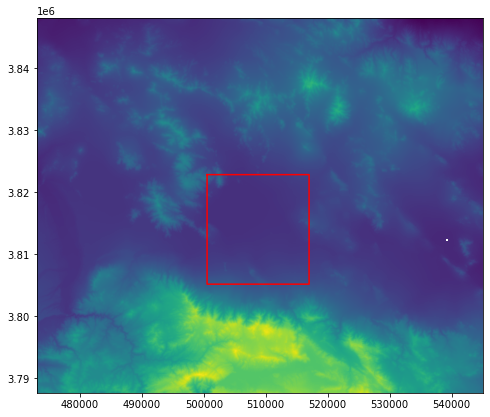

In [4]:
raster = flopy.utils.Raster.load(dem_data)
# crop the area to your shapefile
with shapefile.Reader(grid_boundary) as r:
    grid_bound = r.shape(0)

# inspect the raster and the grid boundary
fig, ax = plt.subplots(figsize=(8, 8))
raster.plot(ax=ax)
xp, yp = list(zip(*grid_bound.points))
plt.plot(xp, yp, "r-");

The raster can be cropped to the grid boundary using the `crop()` function. And then the model boundaries can be accessed using the `.bounds` attribute.

In [5]:
raster.crop(grid_bound)

xmin, xmax, ymin, ymax = raster.bounds
print(raster.bounds)

(500516.9889837423, 516984.4314321875, 3805166.2753174086, 3822849.87619019)


Now that the grid boundaries are known, an initial discretization can be generated.

In the code block below define a `dx`, `dy` (cell size), calculate `nrow` and `ncol` from the model boundaries and the cell sizes, and finally create `delr` and `delc` arrays. The DIS package documentation can be found [here](https://modflow6.readthedocs.io/en/6.2.0/_mf6io/gwf-dis.html) for reference.

In [6]:
dx = dy = 150
nlay = 4

xll = xmin
yll = ymin
nrow = int(np.floor((ymax - ymin) / dy))
ncol = int(np.floor((xmax - xmin) / dx))

delr = np.ones(ncol) * dx
delc = np.ones(nrow) * dy

### Creating an initial model grid instance

In the block below, create an initial model grid instance (it'll get deleted later). This model grid will be used to resample the DEM data to get the top array for the model and to intersect a shapefile that defines the active part of the model grid.

For a full representation of a model grid the following parameters are needed:

   - `delc`: row spacing in the column direction
   - `delr`: column spacing in the row direction
   - `top`: the model's top array. For the temporary grid any elevation can be provided as a 2d array of (nrow, ncol)
   - `botm`: the model's grid cell botm elevations. For the temporary grid this can be faked, but needs to be a 3d array with the dimensions (nlay, nrow, ncol)
   - `idomain`: the model's active and inactive extent. This can also be faked for the temporary grid. It'll be calculated later
   - `xoff`: the lower left corner of the model grid's x coordinate
   - `yoff`: the lower left corner of the model grid's y coordinate
   
Build a temporary model grid, called `temp_grid` in the block below. `flopy.discretization.StructuredGrid()` is used to create structured model grids.

In [7]:
# create a temporary model grid object for resampling, intersections, and performing spatial analysis
top = np.full((nrow, ncol), 100.)
botm = np.zeros((nlay, nrow, ncol))
botm[0] = top - 50
for i in range(1, len(botm)):
    botm[i] = botm[i -  1] - 50

temp_grid = flopy.discretization.StructuredGrid(
    delc=delc,
    delr=delr,
    top=top,
    botm=botm,
    idomain= np.ones((nlay, nrow, ncol), dtype=int),
    xoff=xll,
    yoff=yll
)

f"nrow={temp_grid.nrow}, ncol={temp_grid.ncol}"
temp_grid

xll:500516.9889837423; yll:3805166.2753174086; rotation:0.0; units:undefined; lenuni:0

### Intersecting vector data with a modelgrid

The `GridIntersect` utility class allows users to intersect vector data (shapefile) with modelgrids and will return information about the intersection. In this example the study area boundary is intersected with the modelgrid instance that was created in the previous block to create an `idomain` array for the model.

In [8]:
with shapefile.Reader(study_area) as r:
    aoi = r.shape(0)


# intersect and get the active cell id's
gix = flopy.utils.GridIntersect(temp_grid, method="structured")
# get active cells
result = gix.intersect(aoi, contains_centroid=True)
active_cellids = result.cellids
active_idx = list(zip(*active_cellids))
active_idx.insert(0, tuple([0] * len(active_cellids)))

Create an idomain array and then visualize it using FloPy's PlotMapView.

In [9]:
idomain = np.zeros(temp_grid.shape, dtype=int)
idomain[tuple(active_idx)] = 1 
for lay in range(1, 4):
    idomain[lay] = idomain[0]

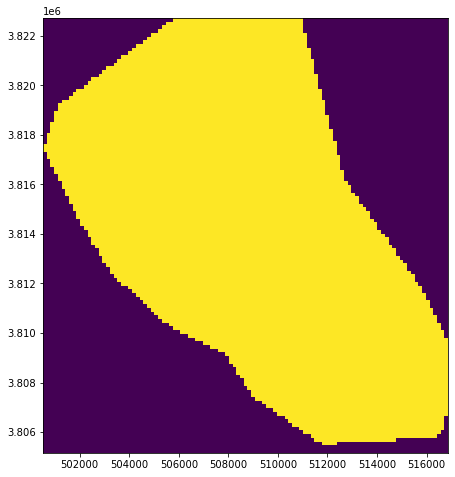

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

pmv = flopy.plot.PlotMapView(modelgrid=temp_grid)
pmv.plot_array(idomain);

### Resampling raster data

The `Raster` class has a `resample_to_grid()` method that allows the user to resample raster data a model grid and/or perform geostatics on rasters. 

There are three parameters that can be supplied to `resample_to_grid()`:
   - `modelgrid`: a flopy.discretization.Grid instance
   - `band`: the raster band to sample
   - `method`: resampling method (more information about the methods can be found [here](https://flopy.readthedocs.io/en/latest/Notebooks/raster_intersection_example.html)

In [11]:
# now we can create our dis file...
top = raster.resample_to_grid(temp_grid, band=raster.bands[0])
top[top == raster.nodatavals[0]] = 1324
botm = np.zeros((nlay, nrow, ncol))
botm[0] = top - 100
for i in range(1, len(botm)):
    botm[i] = botm[i -  1] - 100

C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\rasterstats\io.py:17: DeprecationWarning: ReadingError is deprecated and will be removed in a future version. Use ShapelyError instead (functions previously raising {name} will now raise a ShapelyError instead).
  from shapely.errors import ReadingError


### Create a DIS package

The `flopy.mf6.ModflowGwfdis()` package is used to create a structured rectalinier discretization package in FloPy. The preprocessing that has been done in the prior cells can be used to create this object. Parameters include:

   - `gwf`: the flopy model instance
   - `length_units`: the model length units
   - `xorigin`: the lower left corner x-coordinate
   - `yorigin`: the lower left corner y-coordinate
   - `nlay`: number of model layers
   - `nrow`: number of model rows
   - `ncol`: number of model columns
   - `delc`: row spacing in the column direction
   - `delr`: column spacing in the row direction
   - `top`: the model's top array. 
   - `botm`: the model's grid cell botm elevations.
   - `idomain`: the model's active and inactive extent.
   
Build a `flopy.mf6.ModflowGwfdis()` object

In [12]:
length_units = "meters"

dis = flopy.mf6.ModflowGwfdis(
    gwf,
    length_units="meters",
    xorigin=xll,
    yorigin=yll,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain
)

In [13]:
# remove the temporary model grid instance...
del temp_grid
# and get a copy of the actual model grid instance
modelgrid = gwf.modelgrid

### Making a NPF file

Your friendly coworker is an expert at interpolation and at GIS. They volunteered to do the hard work of analysing drillers logs and creating hydraulic conductivity fields, so you can focus on updating FloPy and MODFLOW 6 Docstrings. 

The original model specs were for a 150 m by 150 m grid, so your coworker sampled created the horizontal conductivity arrays at that discretization. It's likely that the model is not discretized at that discretization anymore. Instead of sending the data back and having your coworker resample it, you decide to resample the array yourself with a handy little function that uses scipy's `griddata` method. Most of the method is complete, but you will need to make a fake model grid to get the cell centers for the conductivity arrays.


In [14]:
def resample_array(modelgrid, raster_extent, array):
    import scipy.interpolate 
    
    xmin, xmax, ymin, ymax = raster_extent
    dx = dy = 150
    
    # make a fake grid here called "fake_grid". 
    # you'll need to define delc, delr, xoff, yoff, top, and botm
    nrow = int(np.floor((ymax - ymin) / dy))
    ncol = int(np.floor((xmax - xmin) / dx))

    delr = np.ones(ncol) * dx
    delc = np.ones(nrow) * dy

    fake_grid = flopy.discretization.StructuredGrid(
        delc=delc,
        delr=delr,
        xoff=xmin,
        yoff=ymin,
        top=modelgrid.top,
        botm=modelgrid.botm
    )
    
    rxc, ryc = fake_grid.xcellcenters.ravel(), fake_grid.ycellcenters.ravel()
    array = array.ravel()
    xc, yc = modelgrid.xcellcenters.ravel(), modelgrid.ycellcenters.ravel()
    
    resampled_array = scipy.interpolate.griddata((rxc, ryc), array, (xc, yc), method="nearest")
    resampled_array[np.isnan(resampled_array)] = 0.10
    resampled_array *= 0.3048
    return resampled_array.reshape((modelgrid.nrow, modelgrid.ncol))
    

#### Build the node property flow package using `flopy.mf6.ModflowGwfnpf()`.

Four parameters are needed to build the node property flow package:
   - `gwf`: the flopy model object
   - `icelltype`: an array that defines if cells are confined or convertable. For this example, set all cells to confined storage
   - `k`: a horizontal conductivity array
   - `k22`: a vertical conductivity array. vk is unkown for this example however you could calculate a vk array using a vertical anisotropy factor...
   

In [15]:
# Load up the HK values into a three dimensional array
hk_array = np.full(modelgrid.shape, 1e-10)
for ix, file in enumerate(hk_files):
    hk = np.genfromtxt(file,)
    hk =  resample_array(modelgrid, raster.bounds, hk)
    hk_array[ix] = hk 
    
vk_array = hk_array * 0.01
icelltype = np.zeros(modelgrid.shape, dtype=int)

npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    icelltype=icelltype,
    k=hk_array,
    k22=vk_array
)


## Initial Conditions

The basin initial condition is not well known, however we do know that there is limited exchange between the upper aquifer and the middle aquifer because of a lacustrine clay layer that acts as an aquitard between the two of them. For this model the intitial condition is set to the highest active elevation in the model.

In [16]:
ic = flopy.mf6.ModflowGwfic(
    gwf,
    strt=1324
)

## Evapotranspiration from a historical lake bed. 

USGS records from Mendenhall (1909) and Thompson (1929) describe a limited amount of natural discharge from the basin from a few springs in the western part of the basin and by evapotranspiration of phreatophytes near the dry Lucerne Lake bed (playa). Near the southwest part of the lake bed cottonwood trees were observed. Sparse pheatophytic vegetation was also observed in other parts of the area.

Phreatophytes in the Mojave deset can grow extremely long tap roots and have large root systems. Mesquite trees have the longest tap roots that can be up to 25 meters deep in some cases. Other phreatophytes have shorter tap roots. For example, the creasote bush has a tap root that extends to a depth of about 1 meter, and cottonwood trees can have tap roots that extend to a depth of about 5 meters. 


In [17]:
with shapefile.Reader(lake_boundary) as r:
    poly = r.shape(0)

df = pd.read_csv(climate_file)
df["year"] = df["Month Year"].apply(lambda x: x.split("-")[0])
df = df.groupby(by=["year"], as_index=False)["Total ETo (mm)"].sum()
eto = df["Total ETo (mm)"].mean() / (1000 * 365.25)
print(eto)

0.004829851699749029


Use `flopy.utils.GridIntersect` to intersect Lucerne Lake with the modelgrid and identify which model cells to simulate evapotranspiration from. 

The process is similar to what was done to identify the active model extent earlier in the notebook.

In [18]:
ix = flopy.utils.GridIntersect(modelgrid)
result = ix.intersect(poly)
cellids = result.cellids
cellid_ix = [tuple([0,] * len(cellids))] + list(zip(*cellids))
rc_ix = tuple(zip(*cellids))
cellids = list(zip(*cellid_ix))


surface = modelgrid.top[rc_ix]
depth = np.full(surface.shape, 5)

Using the cellids, create an evapotranspiration package. Remember to check if each cellid is within the active model extent as you build your evapotranspiration data records.

The `flopy.mf6.ModflowGwfevt()` class is used to build an EVT6 package. The class documentation can be found [here](https://flopy.readthedocs.io/en/latest/source/flopy.mf6.modflow.mfgwfevt.html). The necessary parameters are:
   - `model`
   - `maxbound`
   - `nseg`: this should be 1
   - `stress_period_data`: records of (cellid, surface, et_rate, et_depth, pxdp)

In [19]:
rec = []
for ix, cellid in enumerate(cellids):
    if modelgrid.idomain[cellid[0], cellid[1], cellid[2]]:
        rec.append((cellid, surface[ix], eto, depth[ix], 1.0))

evt = flopy.mf6.ModflowGwfevt(
    gwf,
    maxbound=len(rec),
    nseg=1,
    stress_period_data={0: rec}
)


## Simulating Recharge in the model

The Lucerne Valley is located in the Mojave desert and recieves very little precipitation on the valley floor. Most of the recharge to this basin comes from snowmelt in the San Bernardino mountains to the south. Recharge estimates from the Basin Characterization Model (Flint et. al., 2013) estimate about 680 acre-ft of recharge to the basin.

A recharge zone has been mapped out by your friendly colleague that knows GIS. He got tired of working on code documentation and did this to help you out. When you inspect the shapefile you see that they got a little sloppy with tracing and 20% of the recharge area outside of the model boundaries.

With this information, a recharge package can be built for the model.

In [20]:
conv = 1233.48 # m3 per acre-ft

with shapefile.Reader(recharge_boundary) as r:
    poly = r.shape(0)

recharge = 680 * 1.2 * conv / 365.25 # convert to m3/day and adjust by 1.2 for bad boundaries

Using `GridIntersect` identify the recharge cells and build a recharge package using `flopy.mf6.ModflowGwfrch()`.  The class documentation can be found [here](https://flopy.readthedocs.io/en/latest/source/flopy.mf6.modflow.mfgwfrch.html). The necessary parameters are:
   - `model`
   - `maxbound`
   - `stress_period_data`: records of (cellid, recharge_rate)

In [21]:
ix = flopy.utils.GridIntersect(modelgrid)
result = ix.intersect(poly)
cellids = result.cellids

recharge /= len(cellids)
recharge /= (dx * dy)
print(recharge)
rec = []
for cellid in cellids:
    if modelgrid.idomain[0, cellid[0], cellid[1]]:
        rec.append(((0, cellid[0], cellid[1]), recharge))

rch = flopy.mf6.ModflowGwfrch(
    gwf,
    maxbound=len(rec),
    stress_period_data={0: rec,}
)

0.00015601985552169572


## Simulating model boundaries

Lucerne Valley is bounded on most sides by faults. The western part of the basin is bounded by the Helendale Fault system that runs southest to northwest and seperates the groundwater basin from the greater Mojave basin. In the north an unnamed fault runs east-west from the Granite mountains to the Ord mountains. In the southeast the Cougar Buttes Fault runs in a  southeast to northwest direction and separates the basin from the adjacent Johnson Valley aquifer system. 

These faults have very low estimated conductivity. The Helendale fault and the unnamed northern fault conductivity is estimated to be around 1e-6. The Cougar Buttes fault provides slightly more exchange and has a conductivity between 1e-6 and 1e-5.

Heads across these faults are also higher than those in Lucerne Valley. Head on the west side of the Helendale fault is around 2900 ft asl, north of the unnamed fault is about 2890 ft asl and on the east side of the Cougar Buttes fault is about 2870 ft asl. 

In [22]:
fault_dict = {}
with shapefile.Reader(faults) as r:
    for ix, shape in enumerate(r.shapes()):
        record = r.record(ix)
        fault_dict[record.fault_name] = shape

# tag each fault with it's associated data...

fault_cells = {}
for fault_name, shape in fault_dict.items():
    ix = flopy.utils.GridIntersect(modelgrid)
    result = ix.intersect(shape, return_all_intersections=True)
    fault_cells[fault_name] = list(result.cellids)

print(fault_cells.keys())

dict_keys(['helendale', 'north', 'cougar'])


Using the `fault_cells` dictionary, build a general head boundary condition package to represent faults on the edges of the model with `flopy.mf6.ModflowGwfghb()`. See the previous text block for the head elevations and conductance of each of the faults. 

Documentation for the `flopy.mf6.ModflowGwfghb()` class can be found [here](https://flopy.readthedocs.io/en/latest/source/flopy.mf6.modflow.mfgwfghb.html). Necessary input parameters are: 
   - `model`:
   - `stress_period_data`: records of (cellid, boundary_head, conductance)

In [23]:
# build the GHB package
rec = []
for fault_name, cellid in fault_cells.items():
    for layer in range(modelgrid.nlay):
        for cid in cellid:
            cond = 1e-06 * (100 * dx)
            if fault_name == "helendale":
                bhead = 2890 * 0.3048
            elif fault_name == "north":
                bhead = 2850 * 0.3048
            else:
                cond = 5e-5 * (100 * dx)
                bhead = 2870 * 0.3048
            if idomain[0, cid[0], cid[1]] > 0:
                rec.append(((layer, cid[0], cid[1]), bhead, cond))

ghb = flopy.mf6.ModflowGwfghb(
    gwf,
    stress_period_data={0: rec}
)


## Create an output control package

In [24]:
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    saverecord=[("HEAD", "ALL")],
    head_filerecord="synthetic_desert.hds"
    
)

## Write the simulation to file and run the simulation

In [25]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model synthetic_desert...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package evt_0...
    writing package rch_0...
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 876 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ..\..\..\..\..\AppData\Local\flopy\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

   MODFLOW 6 compiled Dec 10 2022 05:57:01 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been ap

    Solving:  Stress period:     1    Time step:   116
    Solving:  Stress period:     1    Time step:   117
    Solving:  Stress period:     1    Time step:   118
    Solving:  Stress period:     1    Time step:   119
    Solving:  Stress period:     1    Time step:   120
    Solving:  Stress period:     1    Time step:   121
    Solving:  Stress period:     1    Time step:   122
    Solving:  Stress period:     1    Time step:   123
    Solving:  Stress period:     1    Time step:   124
    Solving:  Stress period:     1    Time step:   125
    Solving:  Stress period:     1    Time step:   126
    Solving:  Stress period:     1    Time step:   127
    Solving:  Stress period:     1    Time step:   128
    Solving:  Stress period:     1    Time step:   129
    Solving:  Stress period:     1    Time step:   130
    Solving:  Stress period:     1    Time step:   131
    Solving:  Stress period:     1    Time step:   132
    Solving:  Stress period:     1    Time step:   133
    Solvin

    Solving:  Stress period:     1    Time step:   266
    Solving:  Stress period:     1    Time step:   267
    Solving:  Stress period:     1    Time step:   268
    Solving:  Stress period:     1    Time step:   269
    Solving:  Stress period:     1    Time step:   270
    Solving:  Stress period:     1    Time step:   271
    Solving:  Stress period:     1    Time step:   272
    Solving:  Stress period:     1    Time step:   273
    Solving:  Stress period:     1    Time step:   274
    Solving:  Stress period:     1    Time step:   275
    Solving:  Stress period:     1    Time step:   276
    Solving:  Stress period:     1    Time step:   277
    Solving:  Stress period:     1    Time step:   278
    Solving:  Stress period:     1    Time step:   279
    Solving:  Stress period:     1    Time step:   280
    Solving:  Stress period:     1    Time step:   281
    Solving:  Stress period:     1    Time step:   282
    Solving:  Stress period:     1    Time step:   283
    Solvin

(True, [])

## Load head results and plot

FloPy for modflow-6 has a `.output` attribute on the model object and many of the package objects. The `.output` attribute allows users to easily get head and budget information.

In [26]:
head_obj = gwf.output.head()
heads = head_obj.get_alldata()[-1]

### Plot the head results

FloPy includes plotting utilities that allow users to easily plot model data. `PlotMapView` can be used to plot arrays, shapefile data, discharge vectors, and boundary conditions. 

An example tutorial on `PlotMapView` can be found [here](https://flopy.readthedocs.io/en/latest/Notebooks/plot_map_view_example.html). Plot up the head results and the inactive area of the model grid.

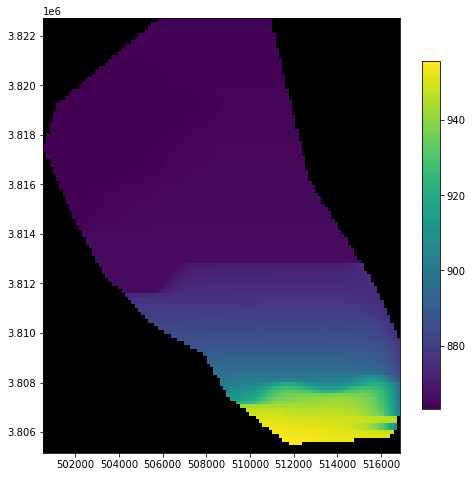

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax, layer=0)

pc = pmv.plot_array(heads, masked_values=[1e+30])
ib = pmv.plot_inactive()
plt.colorbar(pc, shrink=0.8)
plt.show()
heads[heads == 1e+30] = np.nan